In [ ]:
import json
import os
import math
import librosa
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
dataset_path = '/content/drive/MyDrive/lasting_sales_dataset/cus_age_dataset_5sec.json'

In [ ]:
X, y = load_data(dataset_path)

Data succesfully loaded!


In [ ]:
X.shape

(321, 1000, 96)

In [ ]:
# X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)

In [ ]:
# X.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, LSTM, Flatten, Reshape

In [ ]:
model = Sequential()
model.add(Conv2D(60, (3, 3), padding="same", activation="relu", input_shape=(X.shape[1], X.shape[2], 1)))
# model.add(Conv2D(60, (3, 3), padding="same", activation="relu", input_shape=(1000, 96, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.1))
model.add(Conv2D(40, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(4, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(30, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(4, 2)))
model.add(Dropout(0.1))

# Calculate the number of timesteps dynamically based on the output shape of Conv2D layers
conv_output_shape = model.layers[-1].output_shape
num_timesteps = conv_output_shape[1] * conv_output_shape[2]

# Reshape the output from convolutional layers for LSTM input
model.add(Reshape((num_timesteps, 30)))  # Assuming 30 is the number of features

# Add LSTM layers
model.add(LSTM(30, return_sequences=True))  # First LSTM layer with 30 units, return sequences
model.add(LSTM(30, return_sequences=True))  # Second LSTM layer with 30 units, return sequences

# Flatten the output from convolutional layers
model.add(Flatten())

model.add(Dense(84, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1000, 96, 60)      600       
                                                                 
 max_pooling2d (MaxPooling2  (None, 500, 48, 60)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 48, 60)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 48, 50)       27050     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 166, 16, 50)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 166, 16, 50)       0

In [ ]:
model = keras.models.load_model("model_5sec_v2.keras") # load previously saved model

In [ ]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=50)

Epoch 1/50
14/14 [==============================] - 19s 259ms/step - loss: 0.2360 - accuracy: 0.9062 - val_loss: 0.1017 - val_accuracy: 0.9691
Epoch 2/50
14/14 [==============================] - 2s 125ms/step - loss: 0.1698 - accuracy: 0.9375 - val_loss: 0.0881 - val_accuracy: 0.9794
Epoch 3/50
14/14 [==============================] - 2s 122ms/step - loss: 0.1755 - accuracy: 0.9286 - val_loss: 0.1046 - val_accuracy: 0.9588
Epoch 4/50
14/14 [==============================] - 2s 130ms/step - loss: 0.2216 - accuracy: 0.9018 - val_loss: 0.0922 - val_accuracy: 0.9794
Epoch 5/50
14/14 [==============================] - 2s 127ms/step - loss: 0.2000 - accuracy: 0.9152 - val_loss: 0.0964 - val_accuracy: 0.9794
Epoch 6/50
14/14 [==============================] - 2s 123ms/step - loss: 0.1712 - accuracy: 0.9464 - val_loss: 0.0913 - val_accuracy: 0.9897
Epoch 7/50
14/14 [==============================] - 2s 123ms/step - loss: 0.1563 - accuracy: 0.9420 - val_loss: 0.0845 - val_accuracy: 0.9794
Epoch

In [ ]:
model.save('model.keras')

In [ ]:
from google.colab import files
files.download('model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 0s 36ms/step


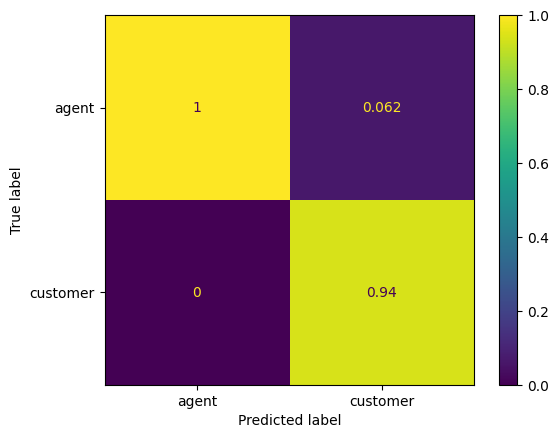

In [ ]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result,display_labels=['agent','customer'])
disp.plot()
plt.show()

In [ ]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_prediction

4/4 [==============================] - 0s 27ms/step


array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
y_test

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0])